## Load marine medium

In [10]:
import pandas as pd

marine_medium = pd.read_csv("cgem/media/minimal_marine_medium_cgem.tsv", sep="\t", header=None)
marine_medium.columns = ["reaction", "flux"]
cpd_classification = pd.read_csv("cgem/media/media_compound_classification.tsv", sep="\t", header=None).set_index(0).squeeze().to_dict()

## Compute exchanges across regions and years

In [2]:
import pandas as pd
from micom.workflows import grow

manifest = pd.read_csv("cgem/communities/manifest.csv")

res = grow(
    manifest,
    model_folder="cgem/communities",
    medium=marine_medium,
    tradeoff=0.5,
    threads=14,
    atol=1.1e-6,
    strategy="pFBA",
    )

res.exchanges.to_csv("cgem/output_communities/exchanges.tsv", sep="\t", index=False)
res.annotations.to_csv("cgem/output_communities/annotations.tsv", sep="\t", index=False)
res.growth_rates.to_csv("cgem/output_communities/growth_rates.tsv", sep="\t", index=False)

## Average exchange fluxes over ecoregions

In [40]:
import pandas as pd
import numpy as np

def create_average_exchanges(input_file, output_file):
    # Read the input TSV file
    df = pd.read_csv(input_file, sep='\t')
    df = df[df.taxon != 'medium']
    
    # Extract year and ecoregion from sample_id
    df[['year', 'ecoregion', 'station']] = df['sample_id'].str.split('_', expand=True)
    
    # Create a new sample_id combining ecoregion and year
    df['new_sample_id'] = df['ecoregion'] + '_' + df['year']
    
    # Group by the relevant columns and calculate the mean flux
    # Note: We're not grouping by 'direction' anymore
    avg_df = df.groupby(['taxon', 'new_sample_id', 'metabolite'])['flux'].mean().reset_index()
    
    # Determine the direction based on the sign of the averaged flux
    avg_df['direction'] = np.where(avg_df['flux'] >= 0, 'export', 'import')
    
    # Rename the new_sample_id column back to sample_id
    avg_df = avg_df.rename(columns={'new_sample_id': 'sample_id'})
    
    # Reorder the columns to match the original format
    avg_df = avg_df[['taxon', 'sample_id', 'flux', 'metabolite', 'direction']]
    
    # Save the averaged dataframe to a TSV file
    avg_df.to_csv(output_file, sep='\t', index=False)
    
    return avg_df


input_file = 'cgem/output_communities/exchanges.tsv'
output_file = 'cgem/output_communities/average_exchanges.tsv'
averaged_df = create_average_exchanges(input_file, output_file)

## Average exchange flux differences between years per ecoregion

In [100]:
import pandas as pd
import numpy as np

def create_flux_difference(avg_exchanges_file, output_file, year1=2015, year2=2016):
    # Read the averaged exchanges file
    df = pd.read_csv(avg_exchanges_file, sep='\t')
    
    # Split the sample_id into ecoregion and year
    df[['ecoregion', 'year']] = df['sample_id'].str.split('_', expand=True)
    df['year'] = df['year'].astype(int)
    
    # Filter for the two years of interest
    df_filtered = df[(df['year'] == year1) | (df['year'] == year2)]
    
    # Pivot the dataframe to have years as columns
    df_pivot = df_filtered.pivot_table(
        values='flux', 
        index=['ecoregion', 'taxon', 'metabolite', 'direction'],
        columns='year', 
        aggfunc='first'
    ).reset_index()
    
    # Rename the year columns
    df_pivot.rename(columns={year1: f'flux_{year1}', year2: f'flux_{year2}'}, inplace=True)
    
    # Fill missing values with 0
    year_columns = [col for col in df_pivot.columns if col.startswith('flux_')]
    df_pivot[year_columns] = df_pivot[year_columns].fillna(0)
    
    # Calculate the difference (year2 - year1)
    df_pivot[f'flux_diff_{year2}-{year1}'] = df_pivot[f'flux_{year2}'] - df_pivot[f'flux_{year1}']
    
    # Sort by absolute difference
    df_pivot['abs_diff'] = abs(df_pivot[f'flux_diff_{year2}-{year1}'])
    df_pivot = df_pivot.sort_values('abs_diff', ascending=False).drop('abs_diff', axis=1)
    df_pivot.dropna(subset=[f'flux_diff_{year2}-{year1}'], inplace=True)
    
    # Save to TSV
    df_pivot.to_csv(output_file, sep='\t', index=False)
    
    print(f"Flux difference data saved to {output_file}")
    
    return df_pivot

In [101]:
avg_exchanges = 'cgem/output_communities/average_exchanges.tsv'
avg_diff = 'cgem/output_communities/flux_differences_2016_2015.tsv'
diff_df = create_flux_difference(avg_exchanges, avg_diff, year1=2015, year2=2016)

Flux difference data saved to cgem/output_communities/flux_differences_2016_2015.tsv


## Heatmap of exchange fluxes per ecoregion and year

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def create_exchange_heatmap(avg_exchanges_file, ecoregion, year,
                            metabolites='all', colormap='viridis',
                            output_file=None, flux_cutoff: float = None):
    # Read the averaged exchanges file
    df = pd.read_csv(avg_exchanges_file, sep='\t')
    
    # Filter for the specified ecoregion and year
    df = df[df['sample_id'] == f"{ecoregion}_{year}"]
    
    # Filter for specified metabolites if not 'all'
    if metabolites != 'all':
        df = df[df['metabolite'].isin(metabolites)]
    
    # Apply flux cutoff if specified
    if flux_cutoff is not None:
        df = df[abs(df['flux']) >= flux_cutoff]
    
    # Pivot the dataframe to create a matrix suitable for a heatmap
    heatmap_data = df.pivot(index='taxon', columns='metabolite', values='flux')
    
    # Replace NaN with 0 for better visualization
    heatmap_data = heatmap_data.fillna(0)
    
    # Remove any columns (metabolites) that are all zeros after applying the cutoff
    heatmap_data = heatmap_data.loc[:, (heatmap_data != 0).any(axis=0)]
    
    # Create the heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(heatmap_data, cmap=colormap, center=0,
                annot=False, fmt='.2f', cbar_kws={'label': 'Flux'})
    
    plt.title(f"Metabolite Exchange Heatmap - {ecoregion} {year}")
    plt.xlabel("Metabolites")
    plt.ylabel("Taxa")
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90)
    
    # Tight layout to ensure all labels are visible
    plt.tight_layout()
    
    # Save the figure if an output file is specified
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Heatmap saved to {output_file}")
    
    # Show the plot
    plt.show()

Heatmap saved to North_2015_heatmap.png


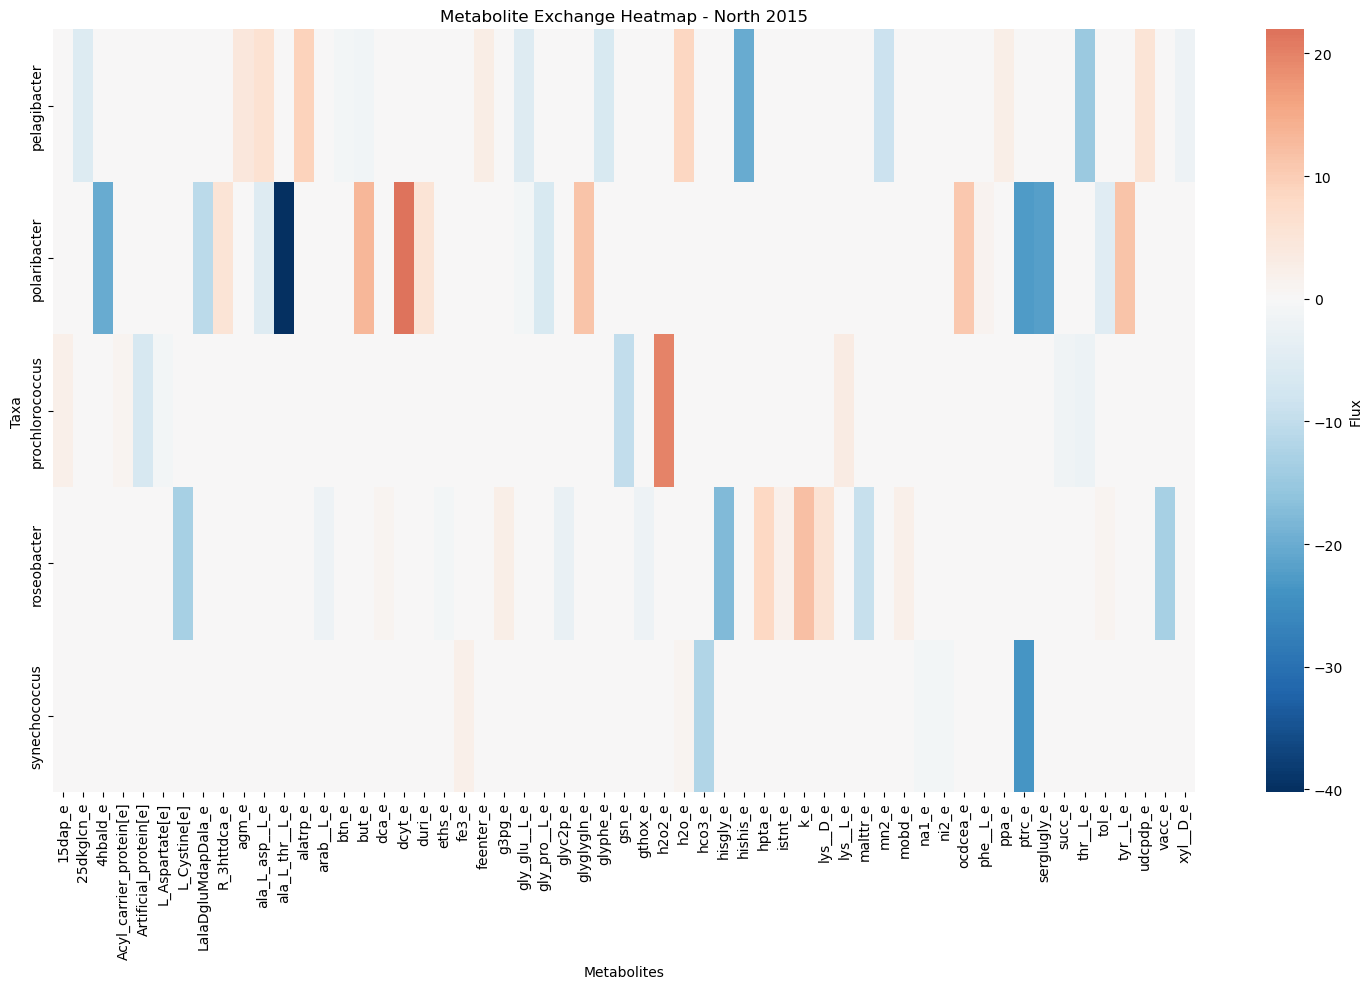

In [36]:
input_file = 'cgem/output_communities/flux_differences_2016_2015.tsv'
input_file = 'cgem/output_communities/average_exchanges.tsv'
create_exchange_heatmap(input_file, 'North', '2015', 
                        metabolites='all',
                        flux_cutoff=1,
                        colormap='RdBu_r', 
                        output_file='North_2015_heatmap.png')

## Represent cross-feeding interactions

Network diagram saved to North_2015_network.png


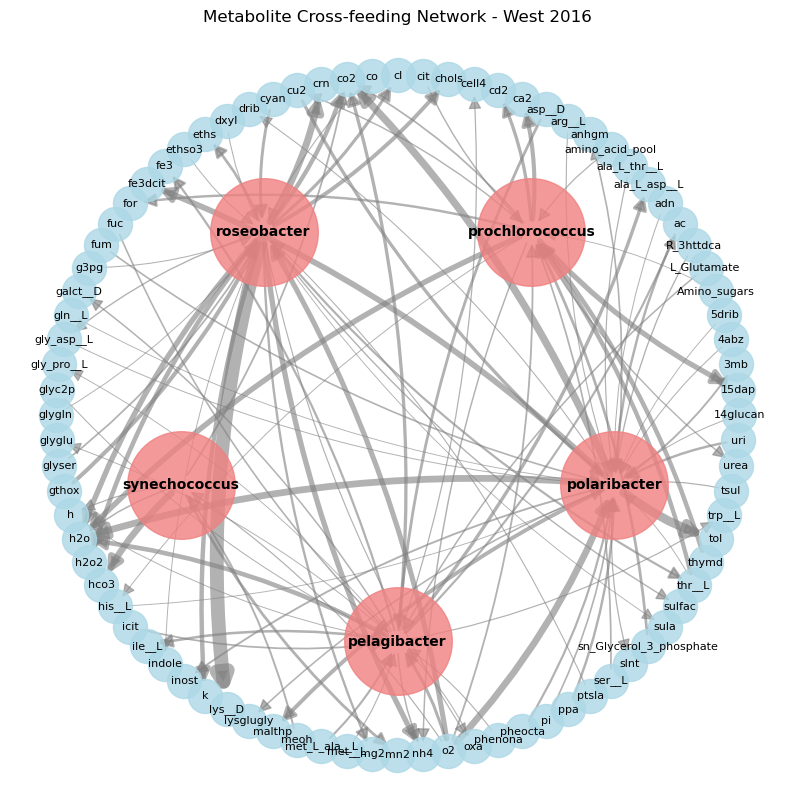

In [65]:
from src.exchanges import create_crossfeeding_network

output_file = 'cgem/output_communities/average_exchanges.tsv'
create_crossfeeding_network(output_file, 'West', '2016', 
                            flux_cutoff=0.1, 
                            taxa_node_size=6000,
                            metabolite_node_size=600,
                            edge_width_factor=10,
                            figsize=(10, 10),
                            output_file='North_2015_network.png')

## Plotting interaction flux differences between years

Network diagram saved to cgem/figures/North_flux_difference_network.png


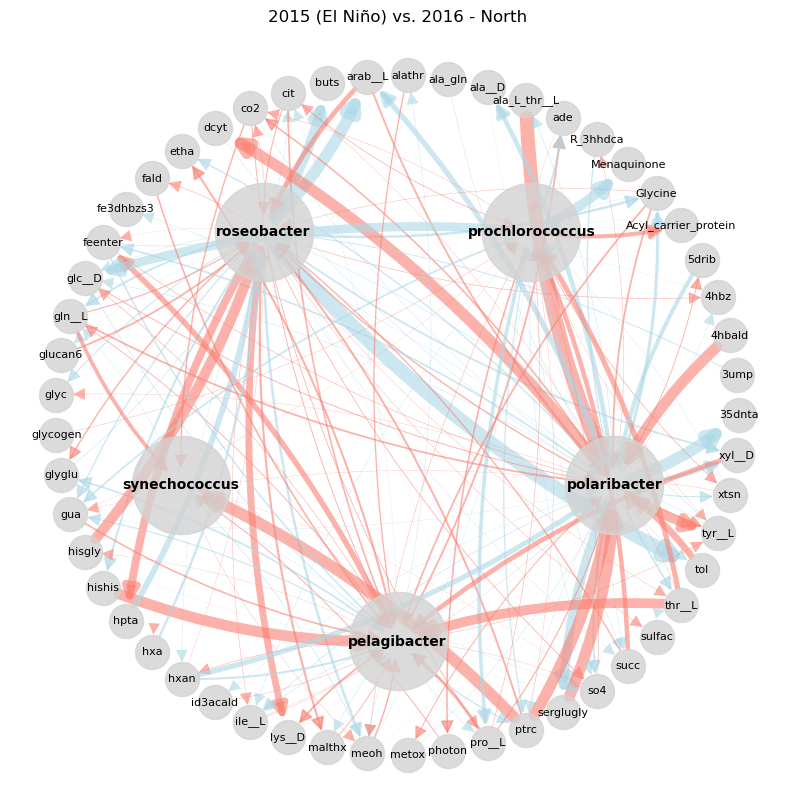

Network diagram saved to cgem/figures/Central_flux_difference_network.png


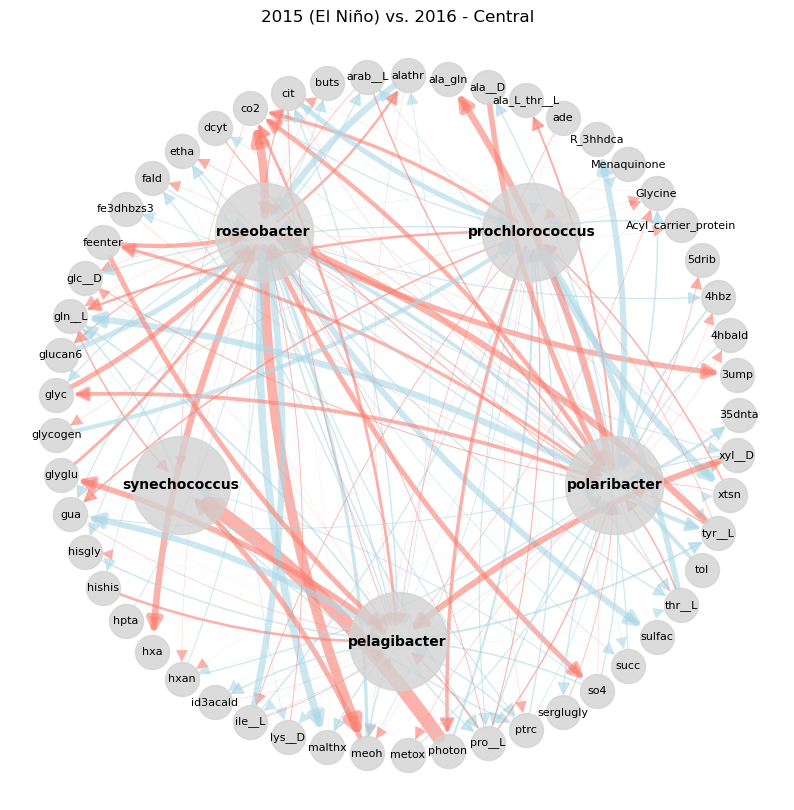

Network diagram saved to cgem/figures/West_flux_difference_network.png


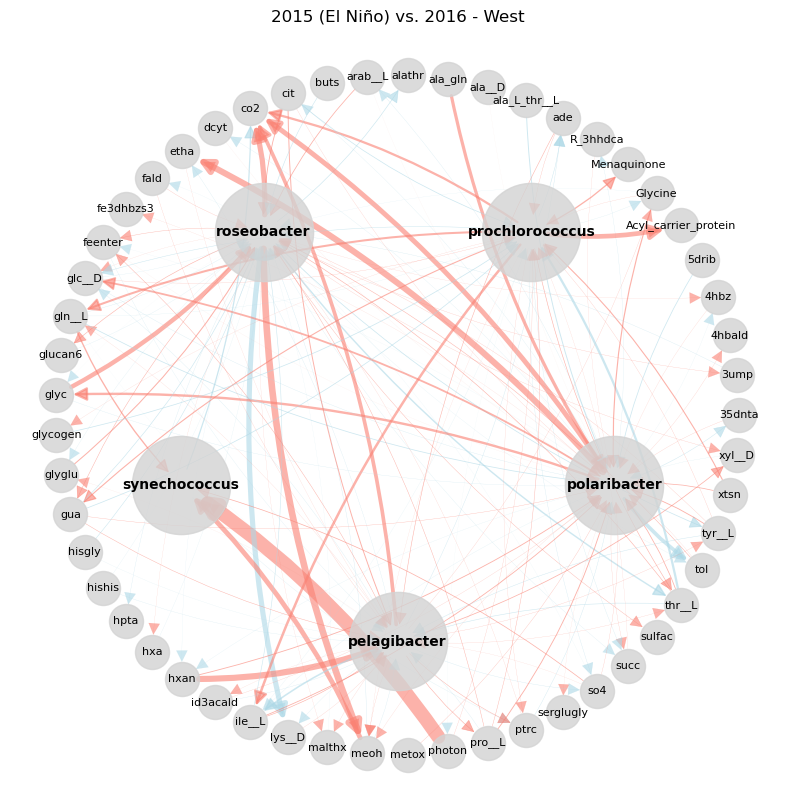

Network diagram saved to cgem/figures/East_flux_difference_network.png


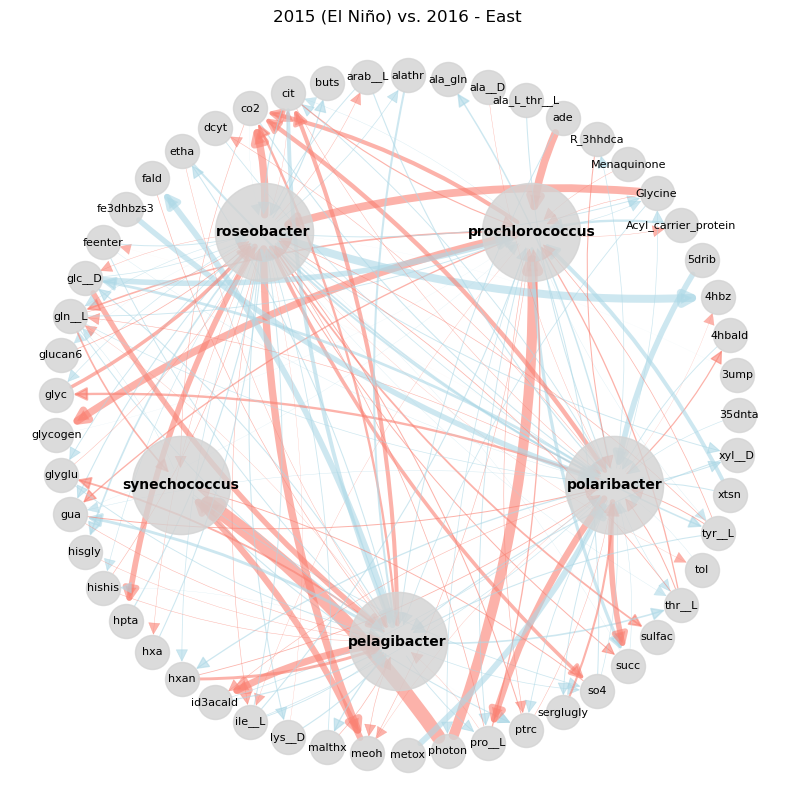

In [134]:
import pandas as pd 
from src.exchanges import create_flux_difference_network

df = pd.read_csv('cgem/output_communities/flux_differences_2016_2015.tsv', sep='\t')

metabolites = df[df["flux_diff_2016-2015"].abs() > 15].metabolite.unique().tolist()

metabolites_to_hide = ['h2o', 'h2o2', 'pi', 'h', 'ca2', 'k', 'S_Adenosyl_4_methylthio_2_oxobutanoate', '4_Methyl_2_oxopentanoate']
metabolites = [m for m in metabolites if m not in metabolites_to_hide]

input_file = "cgem/output_communities/flux_differences_2016_2015.tsv"
ecoregions = ['North', 'Central', 'West', 'East']

for region in ecoregions:
    create_flux_difference_network(input_file, region, 
                                flux_cutoff=0, 
                                taxa_node_size=5000,
                                metabolite_node_size=600,
                                metabolites=metabolites,
                                edge_width_factor=10,
                                edge_width_exp=0.35,
                                figsize=(10, 10),
                                output_file=f'cgem/figures/{region}_flux_difference_network.png',)

## Same but with a heat map

Heatmap saved to cgem/figures/North_flux_difference_heatmap.png


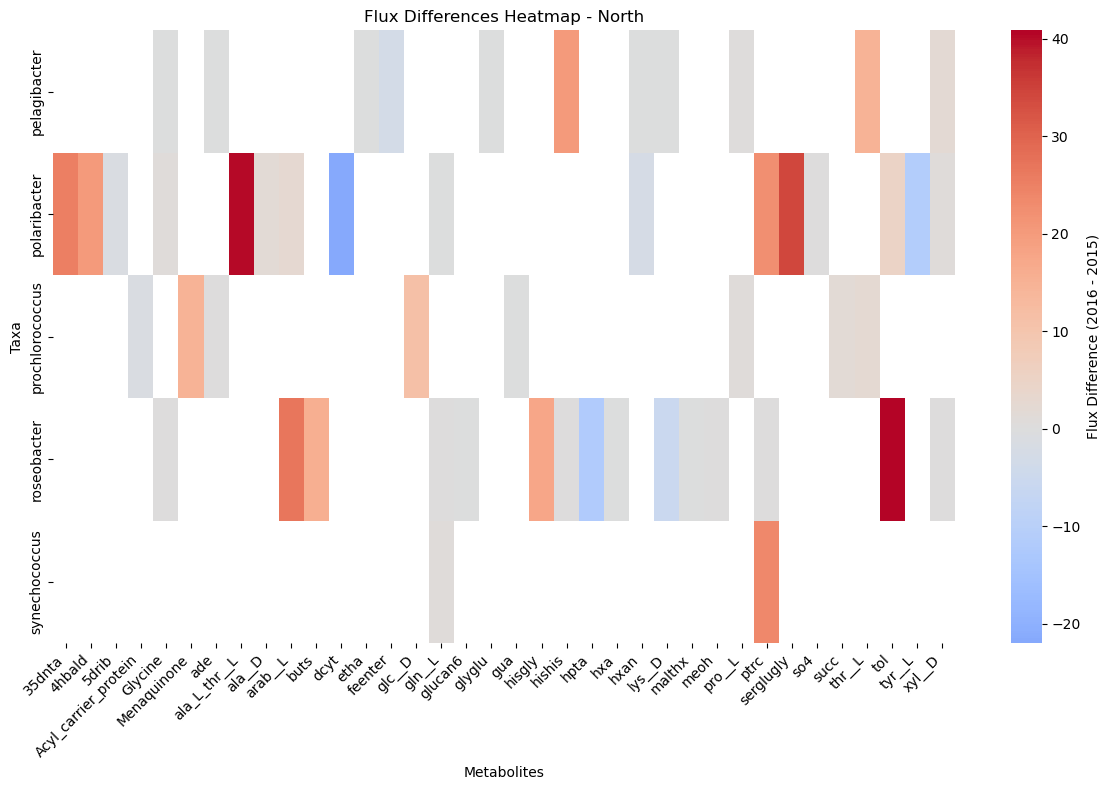

Heatmap saved to cgem/figures/Central_flux_difference_heatmap.png


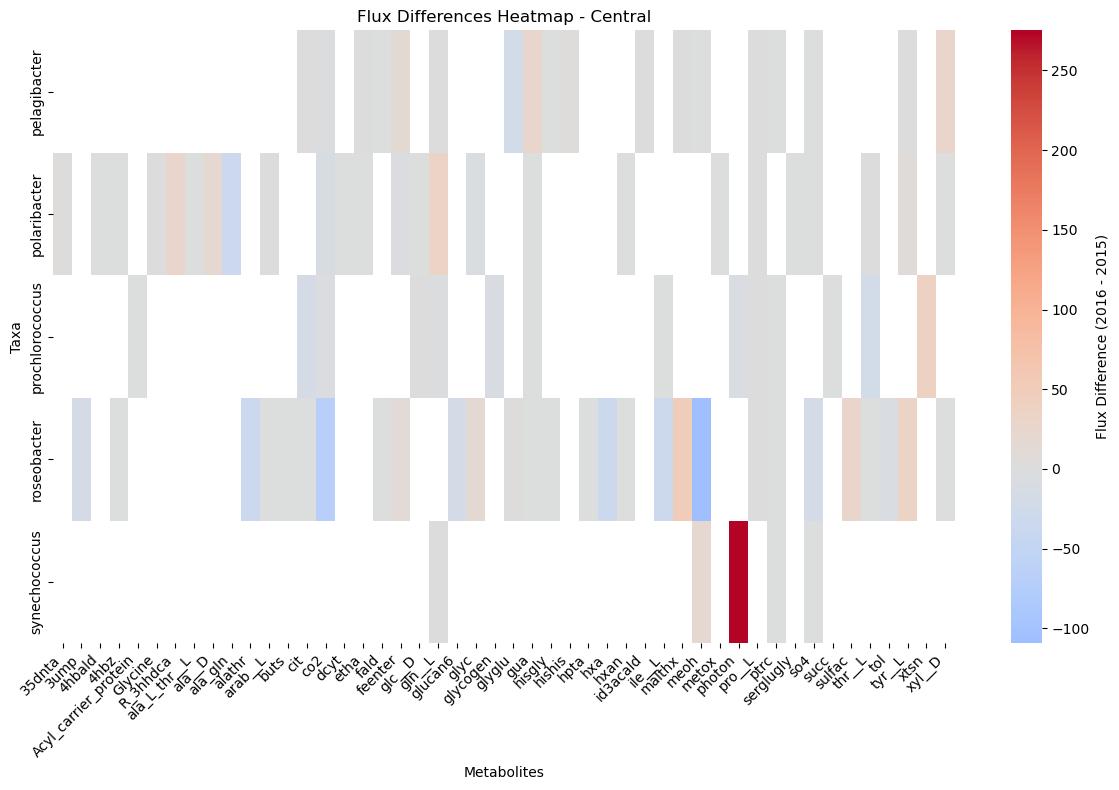

Heatmap saved to cgem/figures/West_flux_difference_heatmap.png


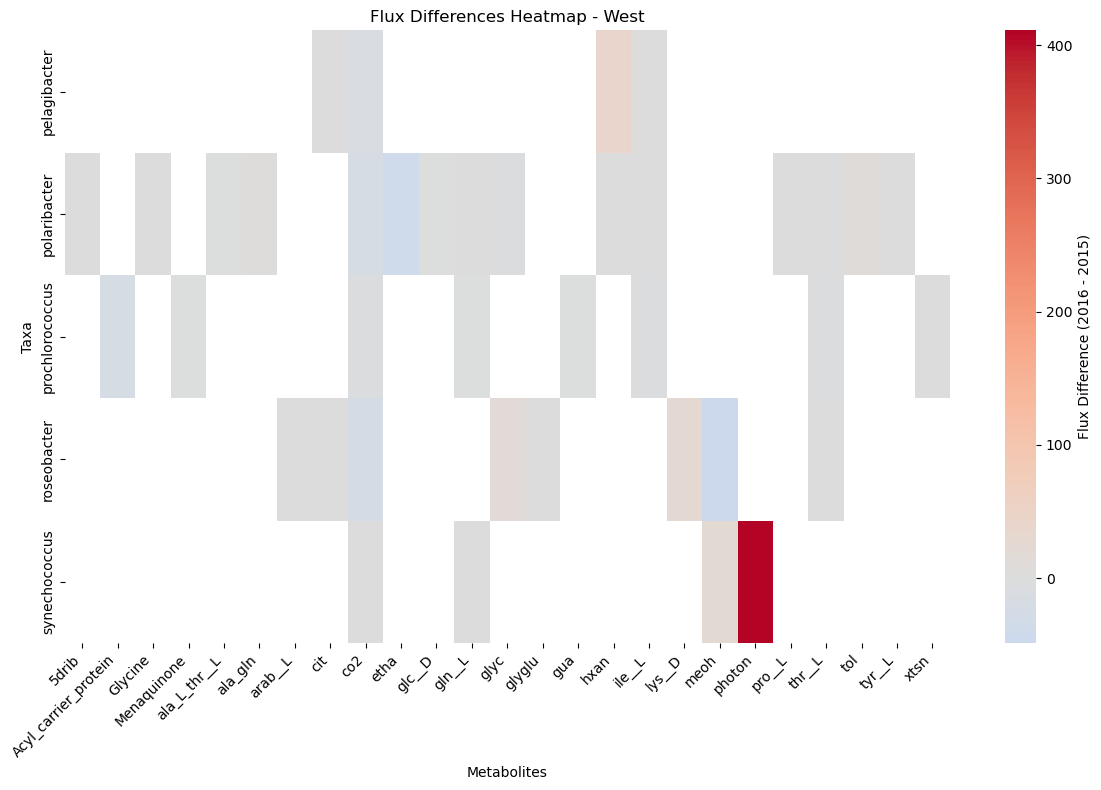

Heatmap saved to cgem/figures/East_flux_difference_heatmap.png


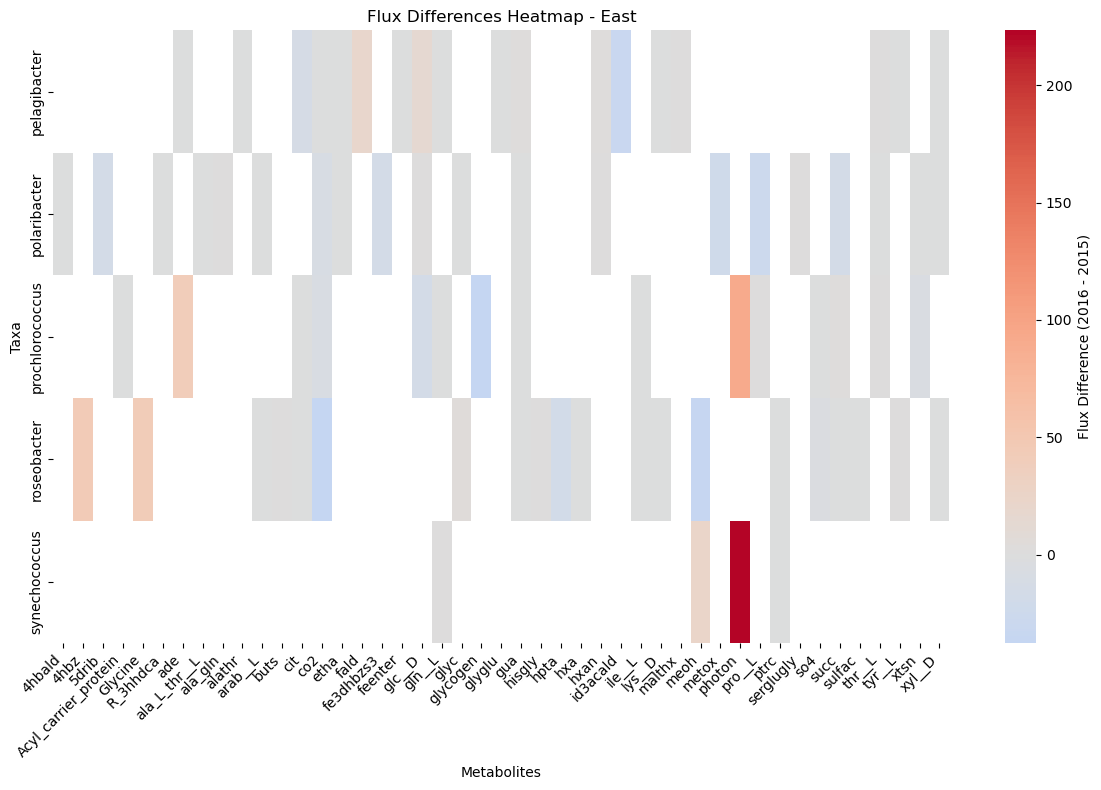

In [138]:
from src.exchanges import plot_flux_difference_heatmap

input_file = "cgem/output_communities/flux_differences_2016_2015.tsv"
ecoregions = ['North', 'Central', 'West', 'East']

for region in ecoregions:
    plot_flux_difference_heatmap(input_file, region, 
                                 flux_cutoff=0.1,
                                 metabolites=metabolites,
                                 figsize=(12, 8),
                                 output_file=f'cgem/figures/{region}_flux_difference_heatmap.png')

## Quantifying cross-feeding interactions

In [50]:
from src.exchanges import create_crossfeeding_dataset

input_file = 'cgem/output_communities/average_exchanges.tsv'
output_file = 'cgem/output_communities/crossfeeding_interactions.tsv'
crossfeeding_df = create_crossfeeding_dataset(input_file, output_file)

Cross-feeding dataset saved to cgem/output_communities/crossfeeding_interactions.tsv


## Visualize cross-feeding interactions

Network diagram saved to North_2015_crossfeeding_network.png


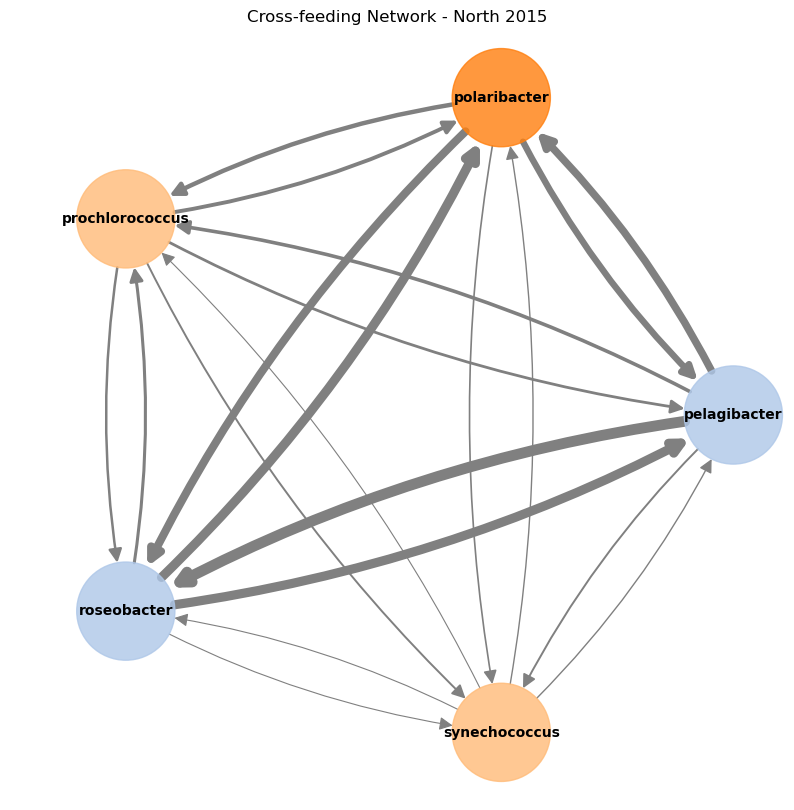

In [17]:
from src.exchanges import visualize_crossfeeding_network

colors = {
    'pelagibacter': '#aec7e8',
    'polaribacter': '#ff7f0e',
    'synechococcus': '#ffbb78',
    'roseobacter': '#aec7e8',
    'prochlorococcus': '#ffbb78'
    }

input_file = "cgem/output_communities/crossfeeding_interactions.tsv"
visualize_crossfeeding_network(input_file, 'North', 2015, 
                               node_size=5000, edge_scale=0.2, min_shared_metabolites=2,
                               figsize=(10, 10), colors=colors,
                               output_file='North_2015_crossfeeding_network.png')

## Analyze differences in cross-feeding interactions between years

In [18]:
from src.exchanges import create_crossfeeding_difference

input_file = 'cgem/output_communities/crossfeeding_interactions.tsv'
output_file = 'cgem/output_communities/crossfeeding_differences_2016_2015.tsv'
diff_df = create_crossfeeding_difference(input_file, output_file, year1=2015, year2=2016)

Cross-feeding difference data saved to cgem/output_communities/crossfeeding_differences_2016_2015.tsv


## Visualize differences in cross-feeding interactions between years

Network diagram saved to cgem/figures/North_crossfeeding_difference_2016_2015.png


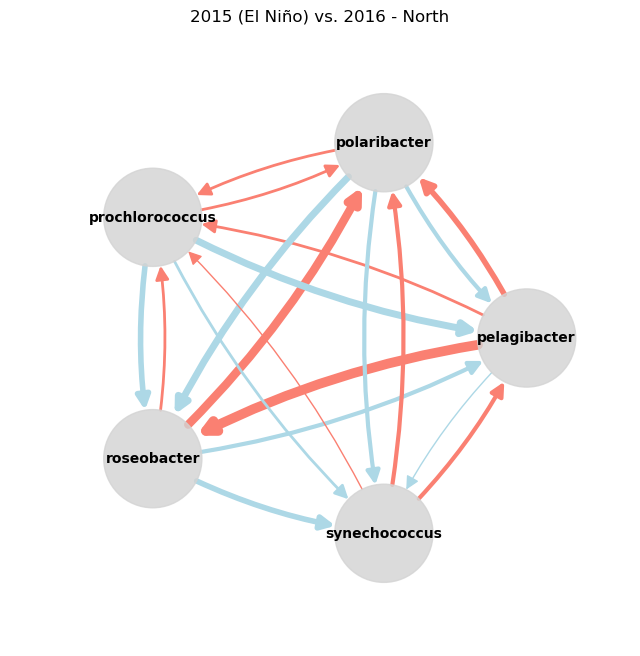

Network diagram saved to cgem/figures/Central_crossfeeding_difference_2016_2015.png


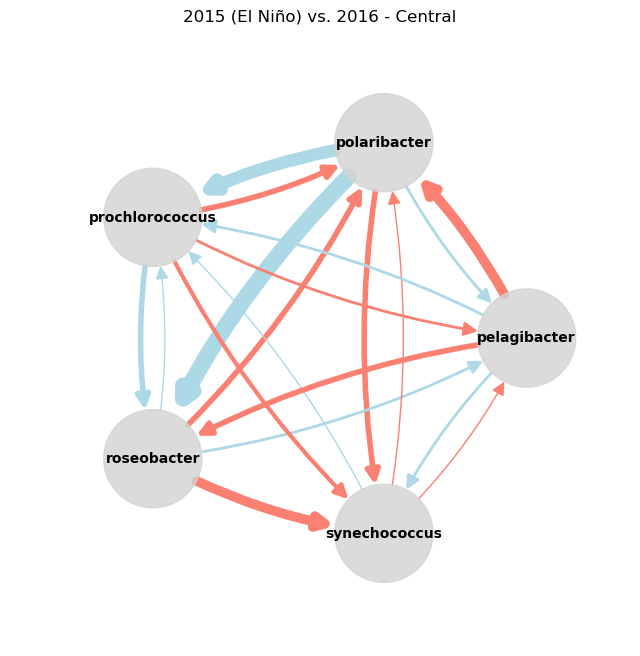

Network diagram saved to cgem/figures/West_crossfeeding_difference_2016_2015.png


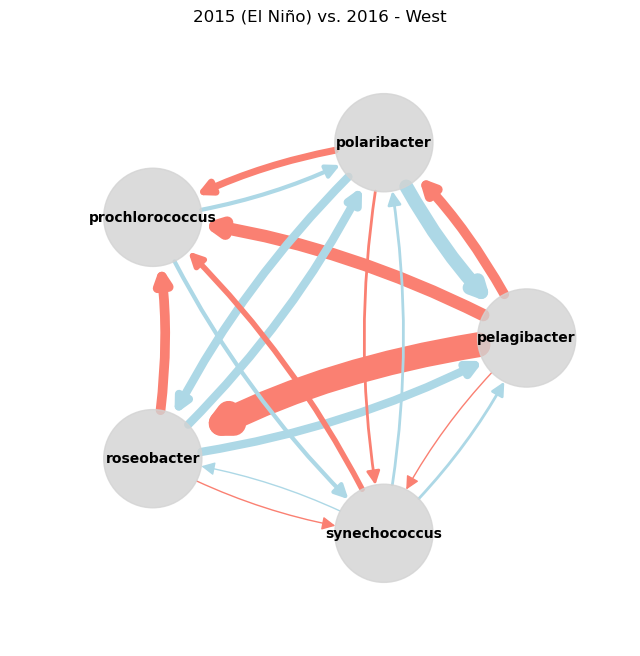

Network diagram saved to cgem/figures/East_crossfeeding_difference_2016_2015.png


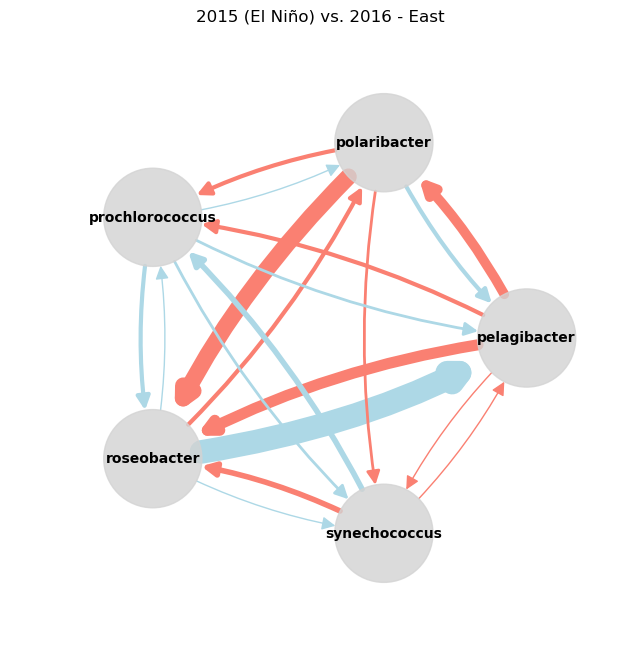

In [122]:
from src.exchanges import visualize_crossfeeding_difference

input_file = 'cgem/output_communities/crossfeeding_differences_2016_2015.tsv'

ecoregions = ['North', 'Central', 'West', 'East']
for region in ecoregions:
    visualize_crossfeeding_difference(input_file, region, 2015, 2016, 
                                    node_size=5000, edge_scale=1.0, min_difference=1,
                                    output_file=f'cgem/figures/{region}_crossfeeding_difference_2016_2015.png',
                                    figsize=(8,8), colors=None)

## Summarize imports and exports

Summary heatmaps saved to cgem/figures/flux_summary_heatmaps.png


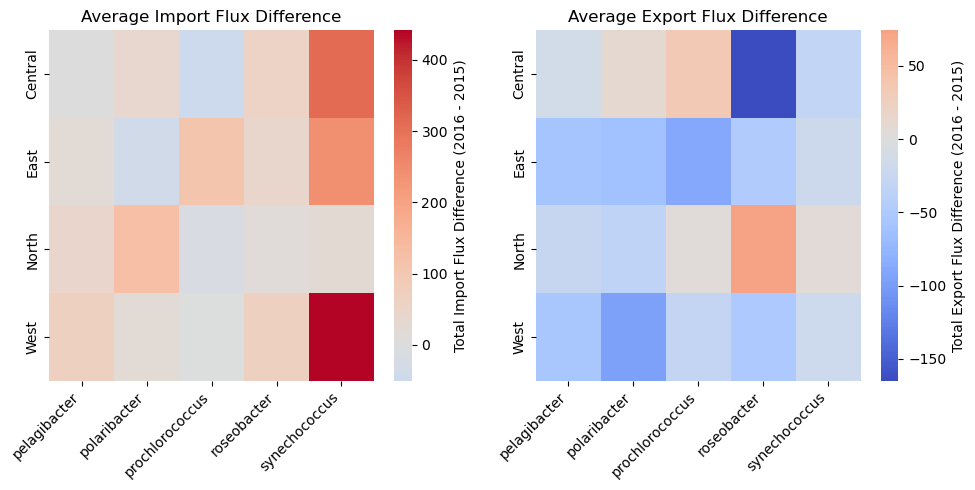

In [148]:
from src.exchanges import plot_flux_summary_heatmaps

input_file = 'cgem/output_communities/flux_differences_2016_2015.tsv'
plot_flux_summary_heatmaps(input_file, 
                           flux_cutoff=1,
                           figsize=(10, 5),
                           output_file='cgem/figures/flux_summary_heatmaps.png')

## Plot degree distribution

Average degree summary plot saved to cgem/figures/average_taxa_degree_summary.png


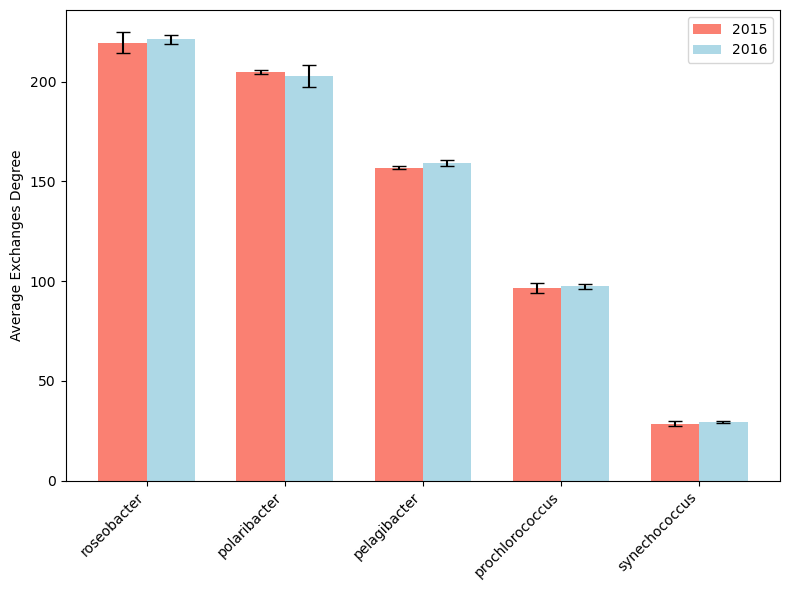

In [161]:
from src.exchanges import plot_average_taxa_degree

input_file = 'cgem/output_communities/average_exchanges.tsv'
plot_average_taxa_degree(input_file, output_file='cgem/figures/average_taxa_degree_summary.png')